# Lecture 18 - Intro to data science (http://bit.ly/2YMjFL6)

Today we're going to look at doing simple machine learning with Python, as an intro to very basic data science.

The idea is not to give you a full knowledge of any single package or technique, rather to give you a sense for what is possible.

To keep things simple, we're going to start by looking at **one variable linear regression**. This is the simplest form of machine learning we can think of. 

For data, we're going to look at an archival database of breast tumor data to try to find variables that predict malignancy. 

#### DATASET http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

#### Link to processed datafile from Google Drive if you want to download:

https://drive.google.com/file/d/1FZbQCEHr2Rie4cXSM6Udg0SaWTtPnEHO/view?usp=sharing

**As a bonus: At the end of this lecture are some notes on three core Python data science libraries that are widely used:  Numpy, Matplotlib and Pandas. These will not be covered in class due to time, but please play with them!**

# Wisconsin Breast Cancer Database

1. Number of Instances: 699 (as of 15 July 1992 (yeah, it's old))

2. Number of Attributes: 10 plus the class attribute

3. Attribute Information: (class attribute has been moved to last column)
   Attribute                     Domain
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)

4. Missing attribute values: 16

   There are 16 instances in Groups 1 to 6 that contain a single missing 
   (i.e., unavailable) attribute value, now denoted by "?".  

5. Class distribution:
 
   Benign: 458 (65.5%)
   Malignant: 241 (34.5%)

# Load the data

First copy the data from Google Drive to a local file.

The data is in a comma separated value (csv) file:

![alt text](https://static.goanywhere.com/images/tutorials/csv-to-database/input-file.png)

* Above is an illustration of CSV format. Each line gives a comma separated sequence of N text strings

* CSV files are like simple tables.


In [7]:
# If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

# Folks - you don't need to understand this, I'm just loading the data from 
# my google drive using Google's API.

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Now proxy the Google Drive file to a local file
cancer_data_import = drive.CreateFile({'id':'1FZbQCEHr2Rie4cXSM6Udg0SaWTtPnEHO'})
cancer_data_import.GetContentFile('cancer_data.csv') # 'cancer_data.csv' is the file name that will be accessible in the notebook.

**Import the Pandas and Numpy modules**

* Numpy is an "array" and "matrix" library, used to represent large collections of data efficiently in Python

* Pandas builds on Numpy to provide a "spreadsheet like" package for manipulating tables of data and performing statistical analyses.

* For more details see the appendices at the end of the notebook and the linked tutorials.

In [8]:
# These are two key libraries we need for representing the data in Python
import numpy as np
import pandas as pd

Next, load the data into Python using Pandas..



In [9]:
# Load the data as a Pandas dataframe

# Read input
df = pd.read_csv("cancer_data.csv") 
df.head(5) # Head just shows us the first 5 rows

,id,clump-thickness,uniformity-of-cell-size,uniformity-of-cell-shape,marginal-adhesion,single-epithelial-cell-size,bare-nuclei,bland-chromatin,normal-nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


This converts process reads the csv table data into a Pandas "data frame", abbreviated "df". 

With df.head(5) we print the first five rows to illustrate the nature of the data.

# Preprocess The Data

In data science and machine learning frequently much of the challenge is in preprocessing the data into a format that is ameniable to the algorithms used.

Here we don't need to do too much, we just normalize the data.

We use scikit-learn, a popular Python machine learning package to do the preprocessing. See: https://scikit-learn.org/stable/modules/preprocessing.html

In [10]:
# Preprocess the data so we can use it for regression. Especially the class values.
# Access function/method docstrings in jupyter via '?'. Ex: preprocessing.LabelEncoder?
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

for col in df.columns: # For each column in the data frame
    df[col] = encoder.fit_transform(df[col]) # Transform the series so is zero based
    # and dense
    
df.head(5)

,id,clump-thickness,uniformity-of-cell-size,uniformity-of-cell-shape,marginal-adhesion,single-epithelial-cell-size,bare-nuclei,bland-chromatin,normal-nucleoli,mitoses,class
0,172,4,0,0,0,1,0,2,0,0,0
1,175,4,3,3,4,6,1,2,1,0,0
2,176,2,0,0,0,1,2,2,0,0,0
3,177,5,7,7,0,2,4,2,6,0,0
4,179,3,0,0,2,1,0,2,0,0,0


# Linear Regression w/One Variable

To start, we suppose we have a set of pairs:

\begin{equation}
(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)
\end{equation}

The task is to try to predict $y_i$ given $x_i$. Call our prediction $y'_i$,  in linear regression we use the following simple linear equation for our prediction:

\begin{equation}
y'_i = w*x_i+b
\end{equation}

In this picture the pairs:

\begin{equation}
(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)
\end{equation}

are the blue dots and our prediction:

\begin{equation}
y'_i = w*x_i+b
\end{equation}

is the red line

![alt text](https://miro.medium.com/max/2584/1*Nf2tTTkALYq6RTMQmhjo1A.png)

In Python we encode the prediction as:

In [11]:
def predict(x, w, b):
    return x*w + b

The task of machine learning here is to learn the parameters of the model, that is $w$ and $b$. To do this we need some way of deciding the value of our parameter choices - a "cost function"

# Cost function / loss function / risk function

The mean squared error (MSE) is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better.

To judge our parameters we use MSE: 
\begin{equation}
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - (wx_i+b))^2
\end{equation}

We visualize this error calculation as shown. 

The error is proportional to the sum of the squared length of the red lines:

![alt text](https://cdn.nextjournal.com/data/QmfPuPp4V74FyvTTojMj6ix9T8Skj1ji4GhX5Pr6zK8w4N?filename=linear-regression.png&content-type=image/png)


In Python:

In [12]:
def cost_function(x, y, w, b):
    n = len(x)
    total_error = 0.0
    for i in range(n):
        total_error += (y[i] - (w*x[i] + b))**2
    return total_error / n

# Gradient descent
Having defined a model and a cost function, the next thing to do is define a learning method which can find good parameters for the model.

For the case of simple linear regression we could calculate the optimum parameters analytically, but here we choose to use gradient descent. An iterative method that can be used to optimize a large class of problems, many of which can not be solved exactly.

In Gradient Descent the idea is to use the derivative (rate of change) of the cost function to iteratively search for the point where the parameters minimize the MSE: 

![alt text](https://miro.medium.com/max/1400/1*HrFZV7pKPcc5dzLaWvngtQ.png)

(In the picture J(w) is the cost function and we traverse the cost function for the w parameter by iteratively moving toward the global minimum)





There are two parameters (coefficients) in our cost function we can control: weight $w$ and bias $b$. Since we need to consider the impact each one has on the final prediction, we use partial derivatives.
Recall the MSE cost function (here called $f$):
\begin{equation}
f(w,b)= \frac{1}{n} \sum_{i=1}^{n} (y_i - (wx_i+b))^2
\end{equation}
First lets find the partial derivative for $w$:
\begin{equation}
\frac{\partial f}{\partial w} = \frac{1}{n} \sum_{i=1}^n -2x_i(y_i - (wx_i+b))
\end{equation}
And the partial derivative for $b$:
\begin{equation}
\frac{\partial f}{\partial b} = \frac{1}{n} \sum_{i=1}^n -2(y_i - (wx_i+b))
\end{equation}


Suppose we have estimates of $w$ and $b$, the gradient descent method estimates  new estimates, $w'$ and $b'$, as follows:

\begin{equation}
w' = w - l * \frac{\partial f}{\partial w}
\end{equation}
And the partial derivative for $b$:
\begin{equation}
b' = b - l * \frac{\partial f}{\partial b}
\end{equation}

Where $l$ is the "learning rate" hyperparameter (a parameter of the learning algorithm) that dictates the speed at which the model learns - moves along the slope.

Given these update equations, we can express them in Python:

In [13]:
def update_weights(x, y, w, b, learning_rate):
    weight_deriv = 0
    bias_deriv = 0
    n = len(x)

    for i in range(n):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        weight_deriv += -2*x[i] * (y[i] - (w*x[i] + b))

        # -2(y - (mx + b))
        bias_deriv += -2*(y[i] - (w*x[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    w -= (weight_deriv / n) * learning_rate
    b -= (bias_deriv / n) * learning_rate

    return w, b

Note: making the learning rate too large will stop the model converging, because the size of the jumps between parameter estimates will hop around the optimal values.

# Train loop

We now have a simple model, cost function and associated learning algorithm. We can put these together to train the model iteratively:



In [14]:
def train_model(x, y, w, b, learning_rate, epochs):
    cost_history = []

    for i in range(epochs):
        w,b = update_weights(x, y, w, b, learning_rate)

        #Calculate cost for auditing purposes
        cost = cost_function(x, y, w, b)
        cost_history.append(cost)

        # Log Progress
        if (i+1) % 20 == 0:
            print("Epochs: ", str(i+1), " cost: ",  str(cost))

    return w, b, cost_history

An epoch is a cycle of learning from the data, the learning rate and number of epochs are the hyperparameters of this algorithm.

# Run the training

Let's test this all out:


In [15]:
x = df['uniformity-of-cell-size']
y = df['class'] # Benign / malignant 
w, b, cost_history = train_model(x, y, 0, 0, 0.02, 500) # Start with w and b as 0, 0
print(w, b)

Epochs:  20  cost:  0.07538027961136255
Epochs:  40  cost:  0.07498926619585158
Epochs:  60  cost:  0.07485402644136209
Epochs:  80  cost:  0.07480725108668539
Epochs:  100  cost:  0.07479107290140467
Epochs:  120  cost:  0.07478547735475996
Epochs:  140  cost:  0.07478354202383664
Epochs:  160  cost:  0.0747828726512064
Epochs:  180  cost:  0.07478264113538957
Epochs:  200  cost:  0.07478256106104562
Epochs:  220  cost:  0.07478253336574431
Epochs:  240  cost:  0.07478252378677425
Epochs:  260  cost:  0.07478252047369835
Epochs:  280  cost:  0.07478251932780343
Epochs:  300  cost:  0.07478251893147433
Epochs:  320  cost:  0.07478251879439674
Epochs:  340  cost:  0.0747825187469841
Epochs:  360  cost:  0.07478251873058646
Epochs:  380  cost:  0.07478251872491373
Epochs:  400  cost:  0.07478251872295176
Epochs:  420  cost:  0.0747825187222749
Epochs:  440  cost:  0.07478251872203892
Epochs:  460  cost:  0.07478251872195751
Epochs:  480  cost:  0.07478251872193077
Epochs:  500  cost:  0.

We can see that the model converges towards better parameters! 

How do we judge how useful the model is in practice? 

# Predictive separation index (PSI) as score
We can use Predictive Separation Index (PSI), to use as the strength of a predictor. The equation is:

\begin{equation}
PSI ( x ) = [ \textrm{mean }  y'_i  \textrm{ when } y_i = 1 ] - [ \textrm{mean }  y'_i  \textrm{ when } y_i = 0 ] \, .
\end{equation}


We want PSI(x) very close to 1 as the first term should be close to 1 and the second term should be close to 0.

In Python:

In [16]:
def get_score(x, y, w, b):
    preds_0 = []
    preds_1 = []
    for i in range(len(x)):
        p = predict(x[i], w, b)
        if y[i] == 0:
            preds_0.append(p)
        else:
            preds_1.append(p)
    if len(preds_0) != 0:
        score = (sum(preds_1) / len(preds_1) - sum(preds_0) / len(preds_0))
    else:
        score = (sum(preds_1) /  len(preds_1) - 0)
    return preds_0, preds_1, score

In [17]:
preds_0, preds_1, score = get_score(x, y, w, b)
print("PSI: ", score)

PSI:  0.6689665943993244


# The prediction distribution plot

A better way to look at our prediction is to look at the distribution of $y'_i$ we get for each of the classes. For $y_i = 0$ the $y'_i$ should be 0. Conversely,  $y'_i$ should be close to 1 when $y_i = 1$. This is a visual way of seeing the strength of a predictor.

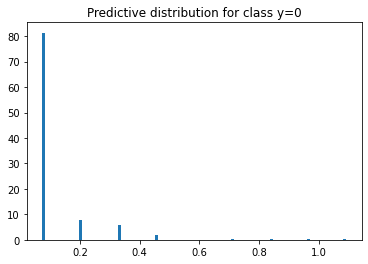

In [64]:
%matplotlib inline  
# The above is required to display matplotlib in jupyter
import matplotlib.pyplot as plt

# The y=0 class
n, bins, patches = plt.hist(preds_0, bins=100, density=1, cumulative=0)
plt.title('Predictive distribution for class y=0')
plt.show()

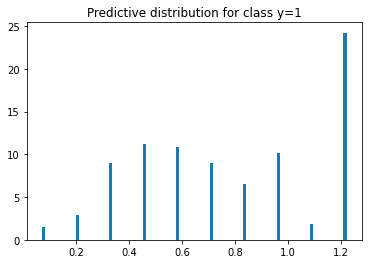

In [63]:
# The y=1 class
n, bins, patches = plt.hist(preds_1, bins=100, density=1, cumulative=0)
plt.title('Predictive distribution for class y=1')
plt.show()

## Use a library to do the same thing! - SciKit Learn

We can use SciKit Learn (sklearn) to do the same thing with a couple lines of code!:



In [19]:
x = df[['uniformity-of-cell-size']]
y = df['class']

from sklearn import datasets, linear_model

lm_model = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=1)
lm_model.fit(x, y)

print("sklearn, w, b, score: ", round(lm_model.coef_[0], 6), round(lm_model.intercept_, 6), round(lm_model.score(x,y), 6))
print("manualr, w, b, score: ", round(w, 6) , round(b, 6), round(score, 6))
# So, we have learned the same co-efficents (or, almost the same) through a library.

sklearn, w, b, score:  0.127488 0.072658 0.668967
manualr, w, b, score:  0.127488 0.072658 0.668967


# Accuracy and Classification

We have create a "regression model", which predicts a continious value. However, what we actually want for this task is a classifier - a model which predicts either "true" (malignant) or "benign" (false). We can make a classifier from our regression model in the simplest way possible: by picking a threshold.

From the above plots it looks like 0.2 is a good cutoff? Let's pick that and look at the accuracy of the model, i.e. how accurate is the model when we say y'_i > 0.2 is "true" but otherwise "false":

In [20]:
y_pred = lm_model.predict(x)
y_pred = [1 if p > 0.2 else 0 for p in y_pred]
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.882689556509299

Not bad! However, there is a lot more to this - we haven't considered:

* Integrating multiple variables
* Switching models - e.g. logisitic rather than linear regression is generally used for classification rather than regression tasks
* Splitting out test data from out training data.

Take a look at the SciKit Learn tutorial if you'd like to dig in more.

# Summary / Lectures Wrap

Okay, we've covered a lot of concepts and shown how we can code from first principles a machine learning algorithm to predict malignancy!

Obviously, we've barely scratched the surface, but you should know that you're now much closer to doing real data science yourself than you were 10 weeks ago.

We've now completed all the lectures - well done and thanks for listening, I appreciate it :)

Next lecture we'll reserve for a revision session.

# Numpy, Pandas, Sklearn and Matplotlib Reading (this won't be on the exam!)

* Browse through the NumPy tutorial here: https://docs.scipy.org/doc/numpy/user/quickstart.html
* Browse through the Pyplot tutorial here:
https://matplotlib.org/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py
* Browse the Pandas 10 min tutorial: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html#min
* Browse through the SciKit Learn tutorial here: https://scikit-learn.org/stable/tutorial/basic/tutorial.html#learning-and-predicting

# Homework

* Zybooks Reading 18




#Appendix - Exploring Numpy, Matplotlib and Pandas

# NumPy Arrays

* NumPy is a Python library for efficiently representing multi-dimensional arrays (e.g. matrices, tensors).

* Pretty much all ML and visualization in Python relies on these array types, or things derived from them.

So far we've seen multi-dimensional arrays using Python lists, e.g.:

In [21]:
# Consider a 2D matrix represented using Python lists

a = [[ 0,  1,  2,  3,  4],
     [ 5,  6,  7,  8,  9],
     [10, 11, 12, 13, 14]]

a[1][0]

5

* The problem is that Python lists are general purpose and flexible and as a result both memory inefficient and really slow.

* This is not a big deal with small data, but when dealing with large amounts of data this becomes of key concern.

* NumPy provides fast, memory efficient array backed multi-dimensional arrays.

We can directly convert to a NumPy 2D array as follows:

In [22]:
import numpy as np # Import the numpy library using the 
# common abbreviation np

a = np.array(a) # Replace the list-of-lists with a numpy 2D array

a

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [23]:
type(a)

numpy.ndarray

In [24]:
# We can address this matrix two ways:

print("The first way", a[1][0]) # This looks familiar

print("The second way", a[1,0]) # This does not look familiar but is shorter and more efficient

The first way 5
The second way 5


So what is going on behind the scenes?

* A NumPy array is represented as contiguous block of memory in which each value is stored in place (not as a reference to separate object):

![alt text](https://github.com/thedataincubator/data-science-blogs/raw/08a364e4cf025b475e95741f97519af94fa6fd38/numpy_and_pandas/figures/row_column_ordering.png)


* As a consequence, arrays have a "data type" corresponding to the way memory is represented for each value stored:

In [25]:
# We can can find out the data type of a NumPy array using the dtype
# variable:

a.dtype # NumPy stores each number as an integer, each using 64 bits

dtype('int64')

If we create an array using floats then the data type will be different:

In [26]:
a = np.array([ 1.0, 2, 4 ])

print(a) # All numbers in the array will be represented as a float

print(a.dtype) # The type is float, again each with 64 bits.

[1. 2. 4.]
float64


The dimensions of a numpy array are stored using the shape and ndim attributes: 

In [27]:
print(a.shape) # The shape of the array (here it has one dimension)

(3,)


In [28]:
print(a.ndim) # The number of dimensions in the array

1


In [29]:
# If we make the array multi-dimensional

a = np.array([[ 0,  1,  2,  3,  4],
              [ 5,  6,  7,  8,  9],
              [10, 11, 12, 13, 14]])

print("The dimensions of the array:", a.shape)
print("The number of dimensions", a.ndim)

The dimensions of the array: (3, 5)
The number of dimensions 2


The size of a numpy array is the size attribute:

In [30]:
print("To get the size of the first dimension use len()", len(a))
print("The total size of the array is the .size attribute", a.size)

To get the size of the first dimension use len() 3
The total size of the array is the .size attribute 15


Building numpy arrays from lists defeats the purpose of trying to save memory.

To make large numeric arrays use zeros(), ones(), empty() or arange()




In [31]:
a = np.zeros((3, 5, 6))

print("Shape:", a.shape)
print("Type", a.dtype) # The default type is 64bit float
print("The array\n", a)

Shape: (3, 5, 6)
Type float64
The array
 [[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]


In [32]:
a = np.ones((2, 5)) # To get an array containing ones

a

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [33]:
a = np.empty((3, 2, 5)) # To get an array with unitialized memory (faster)

a # Note the values have no defined value in this case

array([[[3.71309542e-316, 9.23902758e-322, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000],
        [4.82337433e+228, 6.14415221e-144, 1.16097020e-028,
         6.37112413e-067, 1.48419235e-071]],

       [[3.89412536e-033, 3.97062373e+246, 1.16318408e-028,
         1.26687100e-071, 1.83092966e-076],
        [6.12579926e-062, 4.50666079e-033, 5.04621361e+180,
         8.37170571e-144, 3.80985069e+180]],

       [[3.59751658e+252, 8.76749093e+252, 5.01163215e+217,
         8.37170074e-144, 1.25757916e-071],
        [5.74289295e+174, 9.73746317e-072, 1.48710932e-076,
         1.82629319e+184, 1.58268989e-319]]])

In [34]:
a = np.arange(15)

a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [35]:
a = np.arange(0.0, 3.0, 0.2) # You can do ranges in floating point!

a

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8])

A neat feature of a numpy array is that you can reshape it's dimensions with reshape():

In [36]:
a = a.reshape(3, 5)

print(a)

[[0.  0.2 0.4 0.6 0.8]
 [1.  1.2 1.4 1.6 1.8]
 [2.  2.2 2.4 2.6 2.8]]


# NumPy Slices

NumPy slicing on multi-dimensional arrays lets you quickly get slices of your data:

In [37]:
a # All of a

array([[0. , 0.2, 0.4, 0.6, 0.8],
       [1. , 1.2, 1.4, 1.6, 1.8],
       [2. , 2.2, 2.4, 2.6, 2.8]])

In [38]:
a[:,2] # Just the third elements of the 2nd dimension of the array.

array([0.4, 1.4, 2.4])

In [39]:
a[1,2:] # Just the 3rd and subsequent elements of the 2nd element 
#of the 1st dimension of the array.

array([1.4, 1.6, 1.8])

# NumPy Iterators

In [40]:
for i in a: # By default NumPy iterates over rows
  print(i) 

[0.  0.2 0.4 0.6 0.8]
[1.  1.2 1.4 1.6 1.8]
[2.  2.2 2.4 2.6 2.8]


In [41]:
for i in a.flat: # But you can iterate over all the elements using flat
  print(i)

0.0
0.2
0.4
0.6000000000000001
0.8
1.0
1.2000000000000002
1.4000000000000001
1.6
1.8
2.0
2.2
2.4000000000000004
2.6
2.8000000000000003


# NumPy Builtin Functions

NumPy lets you do math with vectors.

In [42]:
a = np.arange(10)

print(a)

[0 1 2 3 4 5 6 7 8 9]


In [43]:
np.exp(a) # Calculate e**x for each entry x in the array

array([1.00000000e+00, 2.71828183e+00, 7.38905610e+00, 2.00855369e+01,
       5.45981500e+01, 1.48413159e+02, 4.03428793e+02, 1.09663316e+03,
       2.98095799e+03, 8.10308393e+03])

In [44]:
np.sqrt(a) # Calculate sqrt(x) for each entry x in the array

array([0.        , 1.        , 1.41421356, 1.73205081, 2.        ,
       2.23606798, 2.44948974, 2.64575131, 2.82842712, 3.        ])

NumPy has lots of builtin math functions!

# NumPy Operator Overloading

In [45]:
a = np.arange(10)


a + 10 # Add ten to each value

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [46]:
a**2 # Make square of each number

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

etc... each of these operators makes a new array.

To edit the array in place use the increment operators:

In [47]:
a + 10

print(a) # a is not changed

[0 1 2 3 4 5 6 7 8 9]


In [48]:
a += 10 # a is now changed in place.

print(a)

[10 11 12 13 14 15 16 17 18 19]


In [49]:
a **= 2 #ditto

print(a)

[100 121 144 169 196 225 256 289 324 361]


# Linear Algebra Functions

In [50]:
a = np.array([ [1, 2, 3], [4, 5, 6], [ 7, 8, 9]])

print(a)



[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [51]:
a.transpose() # Compute the transpose (rows become columns and vice versa)

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

In [52]:
a @ a # This is matrix multiplication

array([[ 30,  36,  42],
       [ 66,  81,  96],
       [102, 126, 150]])

# Plotting with MatPlotLib

MatPlotLib is a Python plotting library that works with NumPy to make super nice plots. 

It is extremely customizable and can create very fancy plots.

It's pyplot function provides a MATLAB-like interface to the library for making plots.

We can use NumPy and MatPlotLib to create complex data visualization. Here we'll just look at histograms and graphing functions (like on a graphical calculator):

# Histograms

In [53]:
# Build a vector of 10000 samples from a normal distribution with variance 0.5^2 and mean 2
mean, variance_sqrt = 2, 0.5
v = np.random.normal(mean, variance_sqrt, 100000) # Random module allows you to create
# arrays of random numbers drawn from a given distribution.

print(v[:100]) # First 100 members of array

[1.70055992 1.30043357 1.70693918 2.27362291 2.31246949 1.88424835
 1.58146116 2.92824016 1.79634972 2.3699694  2.04365748 2.20992765
 2.22228306 3.12773578 2.05901082 2.01793196 2.50347479 2.29811403
 1.49105499 2.38417863 2.40862189 2.00880862 2.63970828 2.24371705
 2.30053392 1.0551204  2.71051495 2.24659169 1.76264307 2.33133495
 1.9914845  2.29639816 1.67676601 1.85891699 1.58842677 1.99535221
 1.22198459 1.8109965  2.5304442  1.45118997 2.42331936 0.99305884
 1.73075588 1.80101312 2.29804714 2.12497938 2.95581481 2.3080033
 1.79034662 1.52229439 2.00702655 1.83266362 2.97113236 1.71214925
 1.98999875 1.73919328 1.77992231 2.32998606 1.44790481 1.47219336
 1.47177617 1.83981718 2.0295434  2.4364522  2.65552696 1.85747477
 1.71749473 2.23401222 1.83693996 2.08643994 1.81719854 1.5965453
 2.49626779 2.78162801 1.23892416 2.49173578 2.04977899 2.10208781
 1.93544228 2.36958036 1.3884895  1.84351965 1.49296912 2.26677575
 2.2841375  1.27210908 1.70584172 2.46155142 1.43170969 1.643410

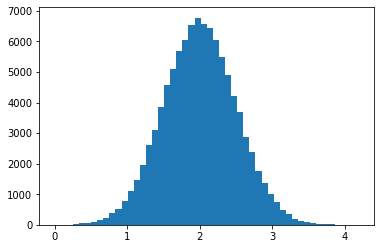

In [54]:
import matplotlib.pyplot as plt # Import pyplot

# Plot a histogram with 50 bins
plt.hist(v, bins=50)       # pyplot call to create a histogram with 50 bins
plt.show() # This call is what causes the plot to create the graphic

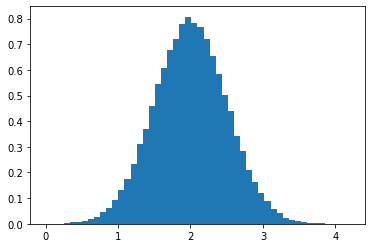

In [55]:
# Plot a normalized histogram with 50 bins
plt.hist(v, bins=50, density=1)  # Density argument normalizes histogram 
plt.show()

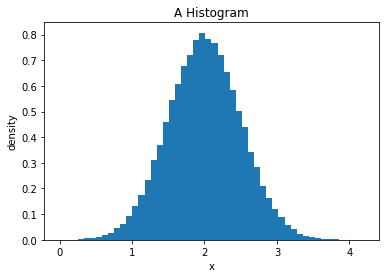

In [56]:
# Plot a normalized histogram with 50 bins and label axes, title, etc.
plt.hist(v, bins=50, density=1)  # Density argument normalizes histogram 
plt.ylabel('density')
plt.xlabel('x')
plt.title('A Histogram')
plt.show()

# Graphing Functions

This allows us to introduce the basic plot command:

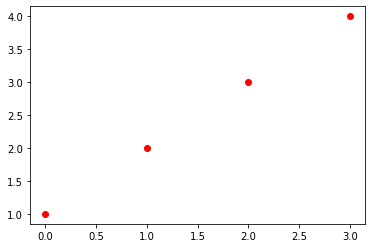

In [57]:
# If you just give it one array (list or numpy array, it assumes that these are the y values)
plt.plot([1, 2, 3, 4], "ro") # "ro" makes pyplot create red points 
plt.show()

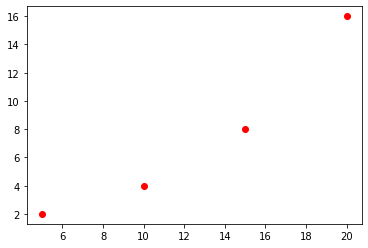

In [58]:
plt.plot([5, 10, 15, 20], [2, 4, 8, 16], 'ro') # If you give it two arrays, it treats
# each pair of elements of the two lists, e.g. (5, 2), (10, 4), etc. as points on the 2D plane
plt.show()

We can use this to graph functions really easily:

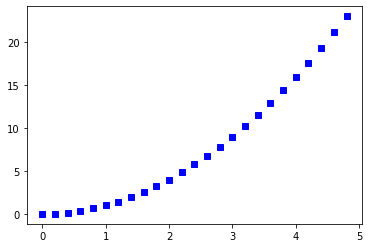

In [59]:
# evenly sampled points from 0 to 5 and 0.2 intervals
t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t, t**2, 'bs')
plt.show()

If we give it multiple pairs of arrays we can show multiple lines on the same plot:

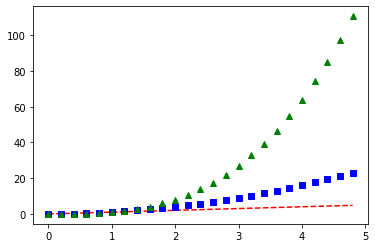

In [60]:
# evenly sampled time at 200ms intervals
t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.show()

# Pandas Series


The basic array object in Pandas is the series object, it is very NumPy array like and most of the stuff we showed for NumPy arrays works with series:

In [61]:
import numpy as np
import pandas as pd # Standard pandas abbreviation to pd

s = pd.Series(np.arange(5))

s

0    0
1    1
2    2
3    3
4    4
dtype: int64

Under the hood it is organized like NumPy, and is mostly compatible and functional like a NumPy array.

However, it is not a multi-dimensional object:

In [62]:
a = np.array([ [ 3, 4, 5], [ 6, 7, 8 ]])

print(a)

s = pd.Series(a) # This doesn't work, because Pandas series are one dimensional

print(s)


[[3 4 5]
 [6 7 8]]


Exception: ignored

# Data Frames

* Panda's Data Frames are 2D "tables". 

* Each column is a series

* Think of them like a spreadsheet, with different columns having different types, etc.:

In [ ]:
a = np.random.randn(6, 4) # Create a matrix of random numbers with 6 rows and 4 columns

print("The numpy array", a)

df = pd.DataFrame(a)

print("The corresponding data frame\n", df)

In [ ]:
df.columns=list('ABCD') # We can name the columns 

df # IF you don't use print, it makes this nice table format in the notebook:

In [ ]:
# We can also name the rows (here we use dates as an example)

dates = pd.date_range('20190501', periods=6) # Make a list of dates as a Pandas series

print("The list of dates\n", dates) # 

df.index=dates # Now give the rows of the matrix these dates

print("\nThe data frame with dates naming the rows:")
df

In [ ]:
# We could have done this all in one line:

df = pd.DataFrame(a, index=dates, columns=list("ABCD"))

df

# Data Frames w/Heterogenous Data 

Data frames can also contain heterogenous types, for example by construction with a dictionary:

In [ ]:
# Here the series are put in a dictionary and the colum indices are the keys

df2 = pd.DataFrame({'A': 1.,
                    'B': pd.Timestamp('20130102'),
                    'C': pd.Series(1, index=list(range(4)), dtype='float32'),
                    'D': np.array([3] * 4, dtype='int32'),
                    'E': pd.Categorical(["test", "train", "test", "train"]),
                    'F': 'foo'})

df2

In [ ]:
df2.dtypes # The types of the different columns

# Data Frame Selection, Slicing and Filter

Data frames are easy to subselect by row or column, allowing you to get subsets of the data easily. 



To select by column name use the square bracket notation:

In [ ]:
df

In [ ]:
df['A'] # Select the 'A' column

To select by row uses square brackets and slice notation:

In [ ]:
df[0:2] # First two rows

To select rows and columns using indexes use the iloc index:

In [ ]:
df.iloc[:, 1:3] # Selects all the rows and the first two columns

To select rows by row and column names use the loc index:

In [ ]:
df.loc['20190502':'20190505', ['A', 'D']]

To filter the rows by a column attribute:

In [ ]:
df[df.A > 0]

Finally, to convert back to a NumPy array use .to_numpy(), then allowing you to slice using NumPy array rules:

In [ ]:
df.to_numpy() # Convert to a numpy array

In [ ]:
df2.to_numpy()

# Data Frame Sorting

It's easy to sort data frames:

In [ ]:
# Sort the column ordering

df.sort_index(axis=1, ascending=False)

In [ ]:
# Sort the rows by value, keying on "B"

df.sort_values(by='B')



# Data Frame Stats

In [ ]:
df.mean() # get the median of each column

In [ ]:
df.median() # get the median of each column

In [ ]:
df.describe() # Calculate summary stats

In [ ]:
# You can even devise your own functions and apply them to each column

def total_range(x):
  return x.max() - x.min()

df.apply(total_range) # This is an example of passing around functions as pointers

# Grouping

If you have multiple rows with the same value, it's easy to group by them:

In [ ]:
df2 # df2 has a test/train split, described by column "E"

In [ ]:
df2.groupby("E").sum() # This groups by the values of column E and then 
# adds up the values which can be summed (dates and strings can't be summed)

# Data Frames and CSVs

It is easy to convert comma separated files into a data frame, and to write to other popular formats (JSON, HDF5, etc.): (see https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#csv-text-files)

In [ ]:
df2

In [ ]:
df2.to_csv('out.csv') # Phew, that was easy - write the df to the file out.csv in CSV format

In [ ]:
# as a reminder, df2 looks like this:

df2

In [ ]:
# Let's just inspect the file real quick:

with open("out.csv") as f:
   for i, l in enumerate(f):
      print("Line:", i, "is: ", l, end="")

In [ ]:
df3 = pd.read_csv('out.csv') # As simple as

df3 # But note that the row index is all messed up..

In [ ]:
# Fix the row index column by telling it to use column 0 as the row index:

df3 = pd.read_csv('out.csv', index_col=0) # Read the csv, telling it that the first row is the
# index of the column names, tell it to respect the dates

df3 # Looks good

In [ ]:
# The one thing to bear in mind, the types of the elements in the table are not necessarily
# preserved:

print("Before writing\n", df2.dtypes)

print("After writing\n", df3.dtypes)

# Data Frames Plotting



In [ ]:
df

In [ ]:
df.plot() # By default makes a line graph of each column

In [ ]:

df2.plot() # Doesn't work - too many different series types

In [ ]:
df2

In [ ]:
df2['A'].plot()